In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162669 sha256=f59e6cd3439c18a44a1ece14f49751ab86df61e64c24f1c916560f851f3cc12b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [5]:
import numpy as np
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [7]:
electronics_data = pd.read_csv('ratings_Electronics.csv',
                      names=['userId', 'productId', 'rating', 'timestamp'],
                      error_bad_lines=False,
                      warn_bad_lines=False)

ratings_original = electronics_data.copy(deep=True)

<ipython-input-7-d9458ca25ae8>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  electronics_data = pd.read_csv('ratings_Electronics.csv',
<ipython-input-7-d9458ca25ae8>:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  electronics_data = pd.read_csv('ratings_Electronics.csv',


In [8]:
electronics_data.head()


,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [9]:
electronics_data.shape

(51778, 4)

In [10]:
print(electronics_data.isnull().sum())


userId       0
productId    0
rating       1
timestamp    1
dtype: int64


In [11]:
!pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


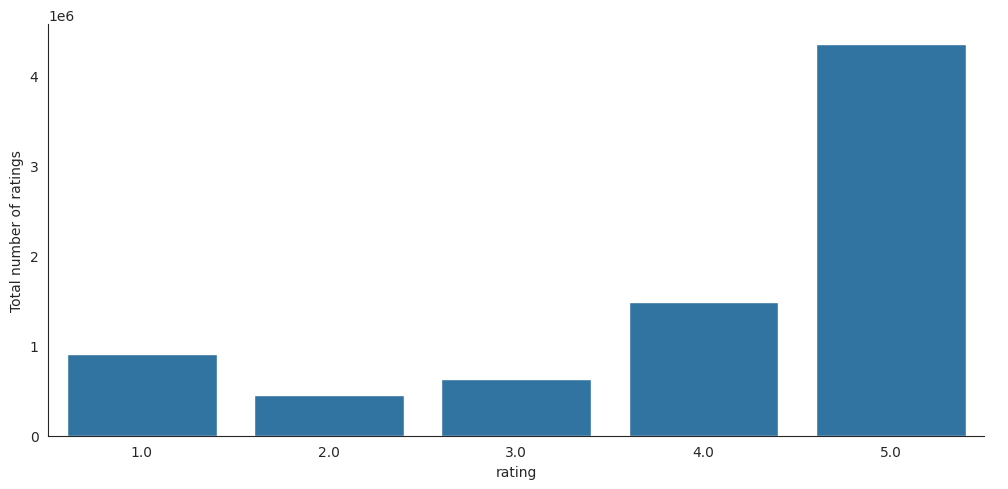

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style('white'):
    g = sns.catplot(x="rating", data=electronics_data, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
    plt.show()


In [12]:

ratings_mean_count = pd.DataFrame(electronics_data.groupby('productId')['rating'].mean())
ratings_mean_count['rating_counts'] = electronics_data.groupby('productId')['rating'].count()


min_ratings_threshold = 50

# Filter out products with fewer than the threshold ratings
popular_products = ratings_mean_count.query('rating_counts >= @min_ratings_threshold')

# Sort the products by average rating and rating counts
popular_products = popular_products.sort_values(['rating', 'rating_counts'], ascending=[False, False])

# Display top N products
top_n = 10
print(popular_products.head(top_n))


              rating  rating_counts
productId                          
B00004TDLD  4.840517            232
B00004TENT  4.823529             51
B00000J4EY  4.735294             68
B00004TJ7O  4.714286             77
B00000JDF6  4.708738            103
B00004SY4H  4.705882            136
B00000J1EP  4.651515             66
9985511476  4.645161             62
B000021YU8  4.634615             52
B00002EQCW  4.626478            423


In [14]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

total_rows = len(electronics_data)
sample_size = min(100000, total_rows)

electronics_data_sample = electronics_data.sample(n=sample_size)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(electronics_data_sample[['userId', 'productId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.3)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

rmse = accuracy.rmse(predictions)


RMSE: 1.6649


In [15]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy



In [16]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(electronics_data[['userId', 'productId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.3)

algo = SVD()

algo.fit(trainset)

predictions = algo.test(testset)

accuracy.rmse(predictions)

from collections import defaultdict

def get_top_n(predictions, n=10):
    # Map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the N highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=5)
# Now you can print out the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

RMSE: nan


nan

Streaming output truncated to the last 5000 lines.
A2DXC3PKBFPQDS ['B00000K2YR']
A27GUMWS9AABBW ['B00003CWDH']
A3EM2H55ODXP71 ['B00001O2YQ']
A3771TJCX8COP3 ['B00004TDSA']
A3S1QHA8SBF8HQ ['B00003006E']
A113Q01OMW9THP ['B00000J061']
ADO31NGW9U6UG ['B000001ON5']
A1C1XLRK3R841B ['0972683275']
A321VPKXFBFRJY ['B00004SD94']
A18UYYCVSTUTIF ['3744295508']
A1PFT6E80P9UF9 ['B00000JXV1']
A3R12OTWU0B5QB ['B00000J4FS']
A2GM0SVPZE01IM ['B00000J4BC']
A1YVXAIV87Z3LM ['0972683275']
A13OMZX5UHL36K ['B00000JDF6']
A1X4WM14KM3QJU ['1400699169']
A1PLH8QRV17A6E ['B00002EQCW']
AJSMJNCHNTJGR ['B00001P4ZH']
AHRFTJL4OO3X2 ['1615527672']
A3UIS41ALL0A8I ['B00004SQET']
A3AAL5TGOW29X3 ['B00000J4CX']
A1QWYAWB1DRSQF ['B00001W0DI']
A1RKA0707KNJ92 ['B00000J1E6']
A234FTGJGCTGZ2 ['B00000J3GR']
A30SYESYSAHU9Q ['B00004S9AK']
A1ILOPL3SAH55I ['B00001P4XH']
AJBOSZVOLCWIW ['B00004SP9W']
A3P9IKVDX1SQWX ['B00000K4LF']
AGIT6MHY1LVU0 ['B00004THD5']
AXCKBNH12QJAG ['B00004SC3K', 'B00001ZVIW']
A1JQPS8ZGV3ZWG ['9985511433']
A3V2U7WYUXM

In [17]:
# Example user ID
example_user_id = 'A3LDPF5FMB782Z'

# Display some past ratings of this user
print("User's Historical Ratings:")
display(electronics_data[electronics_data['userId'] == example_user_id])

# Display top-5 recommended items for this user
print("\nTop-5 Recommended Products:")
if example_user_id in top_n:
    recommended_products = [iid for (iid, _) in top_n[example_user_id]]
    print(recommended_products)
else:
    print("No recommendations available for this user.")


User's Historical Ratings:


,userId,productId,rating,timestamp
1310,A3LDPF5FMB782Z,1400501466,5.0,1.336003e+09
1588,A3LDPF5FMB782Z,1400501520,5.0,1.362874e+09
1696,A3LDPF5FMB782Z,1400501776,5.0,1.334102e+09
2502,A3LDPF5FMB782Z,140053271X,4.0,1.310515e+09
3235,A3LDPF5FMB782Z,1400698987,4.0,1.392854e+09



Top-5 Recommended Products:
['1400501466']
